<a href="https://colab.research.google.com/github/k2moon/ml-hg/blob/main/hp_09_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 순환 신경망으로 IMDB 리뷰 분류하기
---
- 리뷰 긍정과 부정 분류

## 핵심 키워드
---
- 말뭉치
- 토큰
- 원핫인코딩
- 단어 임베딩

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/rickiepark/hg-mldl/blob/master/9-2.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />구글 코랩에서 실행하기</a>
  </td>
</table>

In [1]:
# 실행마다 동일한 결과를 얻기 위해 케라스에 랜덤 시드를 사용하고 텐서플로 연산을 결정적으로 만듭니다. 
import tensorflow as tf

tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()

## 자연어 처리 natural language processing NLP
---
- 컴퓨터를 사용해 인간의 언어를 처리하는 것
- 대표적으로 음성 인식, 기계번역, 감성 분석등
- 말뭉치 : 자연어 처리분야에서의 훈련 데이터

### 토큰 token
---
- 텍스트 데이터의 경우 단어를 숫자로 변경하는 작업이 필요
- 일반적인 방법은 단어마다 고유한 정수를 부여하는 것
- 정수는 단어의 의미나 크기와 관련이 없음
- 일반적으로 영어는 공백으로 단어를 분리 => 토큰 token
- 하나의 샘플은 여러개의 토큰으로 이루어져 있고 1개의 토큰이 하나의 타임스텝에 해당 함

### 어휘 사전
---
- 훈련 세트에서 고유한 단어를 뽑아 만든 목록
- 토큰에 할당하는 정수 중 몇 개는 특정한 용도로 예약 사용
- 0은 패딩, 1은 문장의 시작, 2는 테스트 세트안에 어휘 사전에 없는 토큰


### 한글 문장의 토큰
---
- 한글은 단어에 조사 부분이 있어 형태소 분석을 통해서 분리
- KoNLPy 사용
- KoNLPy 설치 https://konlpy.org/ko/latest/install/
- 네이버 영화 리뷰 분석 1 https://tinyurl.com/4949vmwr
- 네이버 영화 리뷰 분석 2 https://tinyurl.com/ywk9kz6k
- 네이버 영화 리뷰 분석 3 https://wikidocs.net/44249

## IMDB 리뷰 데이터셋
---
- 유명한 인터넷 영화 데이터베이스 imdb.com에서 수집한 리뷰를 감상평에 따라 긍정과 부정으로 분류해 놓은 데이터 셋
- 총 50000개의 샘플, 훈련데이터 25000개, 테스트 데이터 25000개
- 텐서플로에 이미 정수로 바꾼 데이터 사용
- tensorflow.keras.datasets import imdb
- num_words 파라미터로 가장 많이 사용된 어휘 사전 단어수 수 지정
- 훈련 세트와 테스트 세트는 리뷰 텍스트 마다 크기가 달라 파이썬의 리스트를 데이터로 하는 1차원으로 담겨 있음
- Numpy 2차원으로 하기에는 메모리 낭비가 됨

In [1]:
from tensorflow.keras.datasets import imdb

# num_words=500 가장 많이 등장하는 단어 500개 어휘 사전으로 만듦
(train_input, train_target), (test_input, test_target) = imdb.load_data(
    num_words=500)

17464789/17464789 [==============================] - 0s 0us/step


In [2]:
# 각 25000 개
print(train_input.shape, test_input.shape)

(25000,) (25000,)


In [3]:
# 첫 번재 리뷰
print(len(train_input[0]))

218


In [4]:
# 두 번재 리뷰
print(len(train_input[1]))

189


In [5]:
# Numpy의 데이터로 파이썬 리스트가 들어가 있음
type(train_input),type(train_input[0])

(numpy.ndarray, list)

In [6]:
# 첫번째 리뷰 확인, 1문장의 시작, 500개 어휘 사전에 없는 단어는 2로 표시됨
print(train_input[0])

[1, 14, 22, 16, 43, 2, 2, 2, 2, 65, 458, 2, 66, 2, 4, 173, 36, 256, 5, 25, 100, 43, 2, 112, 50, 2, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 2, 2, 17, 2, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2, 19, 14, 22, 4, 2, 2, 469, 4, 22, 71, 87, 12, 16, 43, 2, 38, 76, 15, 13, 2, 4, 22, 17, 2, 17, 12, 16, 2, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2, 2, 16, 480, 66, 2, 33, 4, 130, 12, 16, 38, 2, 5, 25, 124, 51, 36, 135, 48, 25, 2, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 2, 15, 256, 4, 2, 7, 2, 5, 2, 36, 71, 43, 2, 476, 26, 400, 317, 46, 7, 4, 2, 2, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2, 56, 26, 141, 6, 194, 2, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 2, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 2, 88, 12, 16, 283, 5, 16, 2, 113, 103, 32, 15, 16, 2, 19, 178, 32]


In [7]:
# 0 부정, 1 긍정
print(train_target[:20])

[1 0 0 1 0 0 1 0 1 0 1 0 0 0 0 0 1 1 0 1]


In [8]:
# 훈련세트 검증세트로 나누기
from sklearn.model_selection import train_test_split

train_input, val_input, train_target, val_target = train_test_split(
    train_input, train_target, test_size=0.2, random_state=42)

**훈련 세트 살펴 보기**

In [9]:
import numpy as np

lengths = np.array([len(x) for x in train_input])

In [10]:
# 리뷰 평균 단어 갯수, 중간값
print(np.mean(lengths), np.median(lengths))

239.00925 178.0


- 평균이 중간값 보다 커서 왼쪽에 치우친 분포 예상 됨

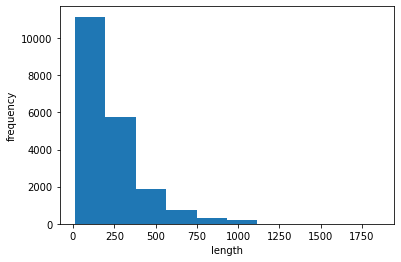

In [11]:
import matplotlib.pyplot as plt

plt.hist(lengths)
plt.xlabel('length')
plt.ylabel('frequency')
plt.show()

### 패딩 padding
---

- 대부분의 길이는 300 미만
- 오른쪽에 아주 1000이 넘는 큰 데이터 있어 평균이 높아 졌음
- 리뷰는 보통 짧으니 100개의 단어를 사용한다고 가정
- 패딩 : 샘플의 길이를 맞추는 작업
- 케라스의 pad_sequences() 메서드 max_len 파라미터 사용
- max_len 보다 큰경우는 잘라내고 작으면 0으로 채움
- truncating 파라미터 앞부분을 버릴 지 뒤를 버릴지 결정, 기본은 `pre`로 앞부분을 버림, 뒷 부분의 정보가 더 유용하다고 기대하기 때문
- 반대는 `post` 지정
- max_len 보다 작은 경우 0값은 앞 부분부터 채워 나감 => **마지막 단어가 셀의 은닉 상태에 가장 큰 영향을 미치기 때문**

In [12]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

train_seq = pad_sequences(train_input, maxlen=100)

In [13]:
print(train_seq.shape)

(20000, 100)


In [14]:
# 0이 없는 것으로 보아 100 보다 큰 리뷰
print(train_seq[0])

[ 10   4  20   9   2 364 352   5  45   6   2   2  33 269   8   2 142   2
   5   2  17  73  17 204   5   2  19  55   2   2  92  66 104  14  20  93
  76   2 151  33   4  58  12 188   2 151  12 215  69 224 142  73 237   6
   2   7   2   2 188   2 103  14  31  10  10 451   7   2   5   2  80  91
   2  30   2  34  14  20 151  50  26 131  49   2  84  46  50  37  80  79
   6   2  46   7  14  20  10  10 470 158]


In [15]:
# 리뷰의 뒷부분 인지 확인
print(train_input[0][-10:])

[6, 2, 46, 7, 14, 20, 10, 10, 470, 158]


In [17]:
# 앞 부분에 패딩 0값이 채워져 있음
print(train_seq[5])

[  0   0   0   0   1   2 195  19  49   2   2 190   4   2 352   2 183  10
  10  13  82  79   4   2  36  71 269   8   2  25  19  49   7   4   2   2
   2   2   2  10  10  48  25  40   2  11   2   2  40   2   2   5   4   2
   2  95  14 238  56 129   2  10  10  21   2  94 364 352   2   2  11 190
  24 484   2   7  94 205 405  10  10  87   2  34  49   2   7   2   2   2
   2   2 290   2  46  48  64  18   4   2]


In [18]:
# 검증 세트 패딩 작업
val_seq = pad_sequences(val_input, maxlen=100)

## 순환 신경망 만들기
---
- 케라스는 여려 종류의 RNN 클래스 제공
- 가장 간단한 것은 SimpleRNN 클래스
- input_shape 입력 차원 지정 (패딩값,어휘 사전 원핫인코딩 크기)
- 원핫인코딩값으로 지정하지 않으면 각 단어마다 지정 했던 값의 크기에 가중치 값이 영향을 크게 받음
- keras.utils.to_categorical() 원핫인코딩 생성
- 이진 분류이므로 출력 층 1개의 뉴런과 시그모이드 활성화 함수 사용해서 생성
 

In [19]:
from tensorflow import keras

model = keras.Sequential()

# output=8 마지막 은닉상태의 뉴런 갯수 지정
model.add(keras.layers.SimpleRNN(8, input_shape=(100, 500)))
# output=1
model.add(keras.layers.Dense(1, activation='sigmoid'))

In [21]:
# 원핫인코딩
train_oh = keras.utils.to_categorical(train_seq)

In [ ]:
# 리뷰 1개 100개의 단어(1차원)가 100 x 500크기의 2차원으로 변환 
print(train_oh.shape)

(20000, 100, 500)


In [22]:
# 첫 번째 리뷰의 첫 번째 단어 10의 변환 값 확인 => 11번째
print(train_oh[0][0][:12])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


In [24]:
# 첫 번째 리뷰의 두 번째 단어 4의 변환 값 확인 => 5번째
print(train_oh[0][1][:12])

[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


In [25]:
# 6 번째 리뷰의 첫 번째 단어 0의 변환 값 확인 => 1번째
print(train_oh[5][0][:12])

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [ ]:
print(np.sum(train_oh[0][0]))

1.0


In [26]:
# 검증 세트 원핫인코딩
val_oh = keras.utils.to_categorical(val_seq)

In [27]:
# RNN 모델 구조 
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 8)                 4072      
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 4,081
Trainable params: 4,081
Non-trainable params: 0
_________________________________________________________________


In [28]:
# 500 입력  * 8 뉴런 + 8 뉴런 * 은닉 뉴런 8 + 절편
param_num = (500 * 8) + (8 * 8) + 8
param_num 

4072

## 순환 신경망 훈련하기
---
- 옵티마이저 rmsprop 별도 생성,  학습률 기본값 0.001이 아닌 0.0004로 지정
- 에포크 횟수 100, 미니 배치 크기 64
- 체크 포인트와 조기 종료 지정

In [29]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model.compile(optimizer=rmsprop, loss='binary_crossentropy', 
              metrics=['accuracy'])

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-simplernn-model.h5', 
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,
                                                  restore_best_weights=True)

history = model.fit(train_oh, train_target, epochs=100, batch_size=64,
                    validation_data=(val_oh, val_target),
                    callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 16s 46ms/step - loss: 0.7011 - accuracy: 0.4983 - val_loss: 0.6959 - val_accuracy: 0.5156
Epoch 2/100
313/313 [==============================] - 14s 43ms/step - loss: 0.6959 - accuracy: 0.5083 - val_loss: 0.6935 - val_accuracy: 0.5246
Epoch 3/100
313/313 [==============================] - 13s 42ms/step - loss: 0.6926 - accuracy: 0.5188 - val_loss: 0.6918 - val_accuracy: 0.5290
Epoch 4/100
313/313 [==============================] - 13s 43ms/step - loss: 0.6900 - accuracy: 0.5276 - val_loss: 0.6903 - val_accuracy: 0.5318
Epoch 5/100
313/313 [==============================] - 15s 47ms/step - loss: 0.6878 - accuracy: 0.5386 - val_loss: 0.6890 - val_accuracy: 0.5334
Epoch 6/100
313/313 [==============================] - 14s 43ms/step - loss: 0.6857 - accuracy: 0.5494 - val_loss: 0.6877 - val_accuracy: 0.5398
Epoch 7/100
313/313 [==============================] - 13s 42ms/step - loss: 0.6834 - accuracy: 0.5595 - val_loss: 0.6864 - val_ac

- 41번째 에포크에서 검증 소실이 줄지 않고 늘어남

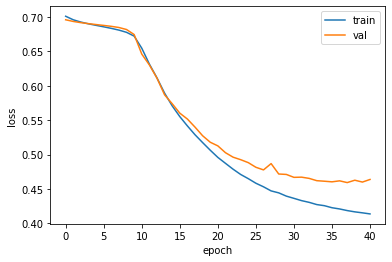

In [30]:
# 훈련 손실고 검증 손실 그래프 확인
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

## 단어 임베딩을 사용하기 word embedding
---
- 원핫인코딩 변환은 입력 데이터가 엄청 커진다는 단점
- 각 단어를 고정된 크기의 실수 벡터로 변환
- 단어 임베딩 벡터는 원핫인코딩보다 의미있는 값으로 채워 자연어 처리에서 더 좋은 성능을 내는 경우가 많음
- 케라스에서는 임베드 층 제공, keara.layers.Embedding 클래스


In [31]:
# 모델 생성
model2 = keras.Sequential()

# 어휘 사전 500, 단어 임베팅 벡터 크기 16, 입력 크기 100 단어
model2.add(keras.layers.Embedding(500, 16, input_length=100))
model2.add(keras.layers.SimpleRNN(8))
model2.add(keras.layers.Dense(1, activation='sigmoid'))

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 16)           8000      
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 8)                 200       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 8,209
Trainable params: 8,209
Non-trainable params: 0
_________________________________________________________________


In [32]:
#  모델 훈련
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model2.compile(optimizer=rmsprop, loss='binary_crossentropy', 
               metrics=['accuracy'])

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-embedding-model.h5', 
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,
                                                  restore_best_weights=True)

history = model2.fit(train_seq, train_target, epochs=100, batch_size=64,
                     validation_data=(val_seq, val_target),
                     callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 8s 23ms/step - loss: 0.6950 - accuracy: 0.5125 - val_loss: 0.6941 - val_accuracy: 0.5054
Epoch 2/100
313/313 [==============================] - 7s 22ms/step - loss: 0.6886 - accuracy: 0.5399 - val_loss: 0.6896 - val_accuracy: 0.5252
Epoch 3/100
313/313 [==============================] - 7s 22ms/step - loss: 0.6828 - accuracy: 0.5687 - val_loss: 0.6849 - val_accuracy: 0.5532
Epoch 4/100
313/313 [==============================] - 7s 21ms/step - loss: 0.6756 - accuracy: 0.5982 - val_loss: 0.6775 - val_accuracy: 0.5808
Epoch 5/100
313/313 [==============================] - 8s 26ms/step - loss: 0.6635 - accuracy: 0.6233 - val_loss: 0.6602 - val_accuracy: 0.6266
Epoch 6/100
313/313 [==============================] - 7s 22ms/step - loss: 0.6207 - accuracy: 0.6891 - val_loss: 0.6144 - val_accuracy: 0.6820
Epoch 7/100
313/313 [==============================] - 7s 23ms/step - loss: 0.5865 - accuracy: 0.7226 - val_loss: 0.5917 - val_accuracy:

- 원핫인코딩보다 더 빨리 조기 종료되고 나은 좋은 결과가 나왔음
```
Epoch 41/100
313/313 [==============================] - 13s 42ms/step - loss: 0.4138 - accuracy: 0.8187 - val_loss: 0.4638 - val_accuracy: 0.7818
```

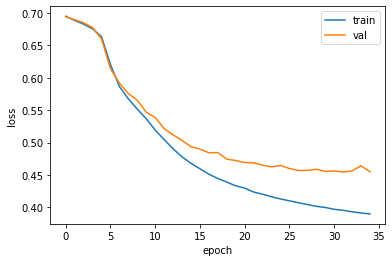

In [33]:
# 훈련 손실과 검증 손실 그래프
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()